In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

import src.utils as utils
from bimvee.importIitYarp import importIitYarp

In [2]:
## import data
sequence_name = "s1_v1"
path = os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", sequence_name)

try:
    events = importIitYarp(filePathOrName=path)
except Exception as e:
    print("could not import data")
    print(e)
    exit

importIitYarp trying path: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1
Examining info.log: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1/info.log


In [3]:
with open(path + "/positions.csv", newline='') as csvfile:
    positions = np.loadtxt(csvfile)
with open(path + "/timing_press.csv", newline='') as csvfile:
    press_timing = np.loadtxt(csvfile)

In [4]:
# the roi center is the button position
roi_center = [
    positions[0, [2, 4]].sum() / 2,
    positions[0, [1, 3]].sum() / 2
]
# the roi edge is manually selected close the the person
roi_edge = [
    positions[1, [2, 4]].sum() / 2,
    positions[1, [1, 3]].sum() / 2
]

Window size: [237, 298]
Detection threshold: 49438.200000000004

Mean: 0.4217244292471764,
min: 0.2581153135481671,
max: 0.6786452038709392

Window size: [237, 298]
Detection threshold: 4943.820000000001

Mean: 0.5146319087464247,
min: 0.39057913765474694,
max: 0.7302071206094745

Window size: [237, 298]
Detection threshold: 494.382

Mean: 0.5267915054945161,
min: 0.4087873967895206,
max: 0.7380659829413823

Window size: [237, 298]
Detection threshold: 49.4382

Mean: 0.5727233990883462,
min: 0.460003454627234,
max: 0.7946377071157826



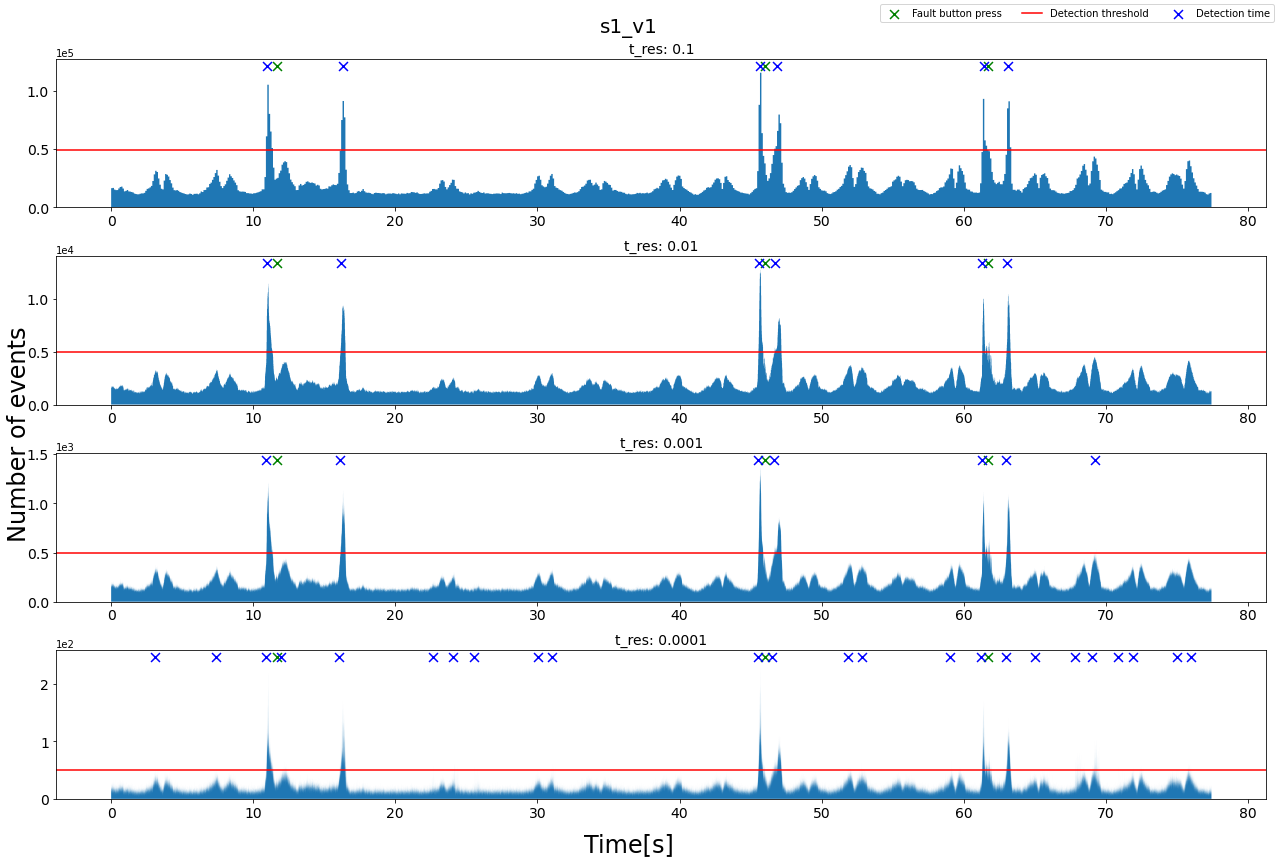

In [14]:
scale = 0.8
# dataset_tres_ls = [0.1, 0.01, 0.001, 0.0002, 0.0001]
dataset_tres_ls = [10**(-x) for x in range(1, 5)]
base_thresh = 7
t_start = 0
t_end = np.inf
press_timing = press_timing[
    np.logical_and(press_timing[:, 0] > t_start,
                   press_timing[:, 0] < t_end) 
]

fig, axs = plt.subplots(len(dataset_tres_ls), 1, figsize=(18, 12))

mean_differences = []
n_detections = []

for ax, dataset_tres in zip(axs, dataset_tres_ls):

     # scale controlls the radius scale
    roi = utils.get_roi(roi_center, roi_edge, scale=scale)
    roi[0] = np.clip(roi[0], 0, 640) # hardcoded img resolution
    roi[1] = np.clip(roi[1], 0, 480)

    ts_filt, window_size = utils.get_events_roi(events, roi)

    h, bins, _ = utils.plot_hist(ax, ts_filt, dataset_tres, t_start=t_start, t_end=t_end)
    # get y val for markers to be on the top of the plot
    plt_y_lim = ax.get_ylim()
    v = plt_y_lim[1]

    detection_thresh = (base_thresh * dataset_tres) * (window_size[0] * window_size[1])

    utils.plot_press_times(ax, press_timing, yval=v)
    detection_times = utils.plot_detections(ax, h, detection_thresh, bins, dataset_tres, yval=v)

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(labelsize=14)
    ax.set_title(f"t_res: {dataset_tres}", fontsize=14)

    differences = utils.measure_time_difference(detection_times, press_timing)
    mean_differences.append(np.mean(differences))
    n_detections.append(len(detection_times) - len(press_timing))
    print(f"\nMean: {np.mean(differences)},\nmin: {np.min(differences)},\nmax: {np.max(differences)}\n")


fig.suptitle(sequence_name, fontsize=20)
fig.supxlabel("Time[s]", fontsize=24)
fig.supylabel("Number of events", fontsize=24)

lines, labels = fig.axes[-1].get_legend_handles_labels()
plt.figlegend(lines,labels, ncol=3)

fig.tight_layout()


Text(0.5, 1.0, 'Mean time difference')

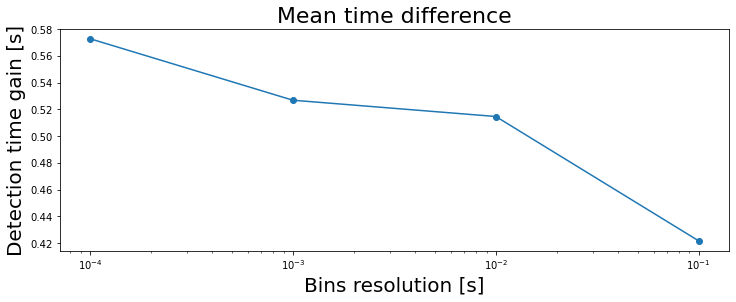

In [15]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dataset_tres_ls, mean_differences, marker="o")
ax.set_xticks(dataset_tres_ls)
ax.set_xscale('log')
ax.set_xlabel("Bins resolution [s]", fontsize=20)
ax.set_ylabel("Detection time gain [s]", fontsize=20)
ax.set_title("Mean time difference", fontsize=22)


Text(0.5, 1.0, 'False detections')

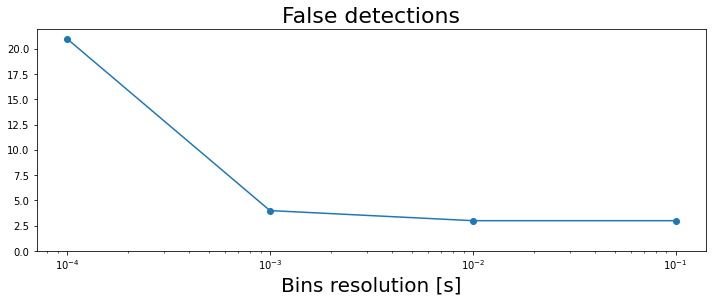

In [16]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dataset_tres_ls, n_detections, marker="o")
ax.set_xticks(dataset_tres_ls)
# ax.set_yticks(n_detections)
ax.set_ylim([0, max(n_detections) + 1])
ax.set_xscale('log')
ax.set_xlabel("Bins resolution [s]", fontsize=20)
# ax.set_ylabel("number of detections", fontsize=20)
ax.set_title("False detections", fontsize=22)
